# **Import Libraries**

In [1]:
import numpy as np
import os
import collections
import shutil
import matplotlib.pyplot as plt
from PIL import Image 
from tqdm.notebook import tqdm
import json

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# **Load and Seperate Data**

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks (1)/AI_Climate/JUA1.zip'

In [4]:
# Read .json file
json_file = open("/content/JUA/module_metadata.json", "r", encoding="utf-8")
sh_json= json.load(json_file)
json_file.close()

In [5]:
path = '/content/JUA/'

In [6]:
# Create dataset directory
if not os.path.exists('/content/dataset'):
  os.mkdir('/content/dataset')

In [7]:
# Read labels from the .json file
labels = []
for i in tqdm(sh_json):
  label = sh_json[i]['anomaly_class']
  labels.append(label)

Total number of classes found: 12
Classes:  ['Cell' 'Cell-Multi' 'Cracking' 'Diode' 'Diode-Multi' 'Hot-Spot'
 'Hot-Spot-Multi' 'No-Anomaly' 'Offline-Module' 'Shadowing' 'Soiling'
 'Vegetation']


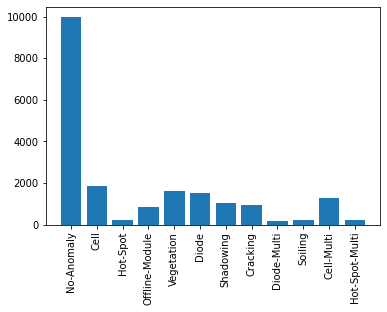

In [8]:
# Data distribution
classes = np.unique(labels)
print(f'Total number of classes found: {len(classes)}')
print('Classes: ',classes)

freq = collections.Counter(labels)
plt.bar(freq.keys(), freq.values())
plt.xticks(rotation='vertical')
plt.show()

* From the above plot, it can be observed that the data is **imbalanced**.
* I tried using **Image Augmentation** and using **balanced class weights**.

In [ ]:
# Seperate images according to their respective classes

In [9]:
# Create directory for each class
for i in classes:
  if not os.path.exists('/content/dataset/' + i):
    os.makedirs('/content/dataset/' + i)

In [10]:
# move images
for j in tqdm(classes):
  for i in sh_json:
    if j == sh_json[i]['anomaly_class']:
      shutil.move('/content/JUA/' + sh_json[i]['image_filepath'] , '/content/dataset/' + j)

# **Visualisation**

Visualising the images, their histograms, and applying filters on them

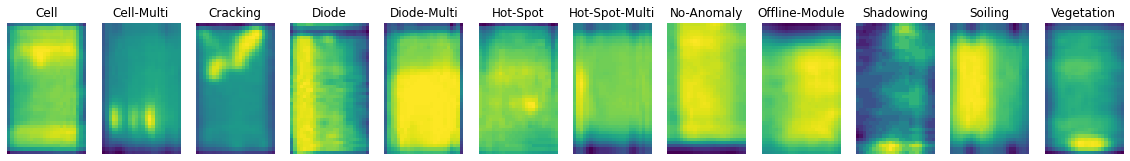

In [139]:
fig = plt.figure(figsize=(20, 3.5))
for index, label in enumerate(classes):
  ax = plt.subplot(1, 12, index + 1)
  files = os.listdir('/content/dataset/' + label)
  plt.imshow(Image.open('/content/dataset/' + label + '/' + str(files[0])))
  plt.title(label)
  plt.axis('off')

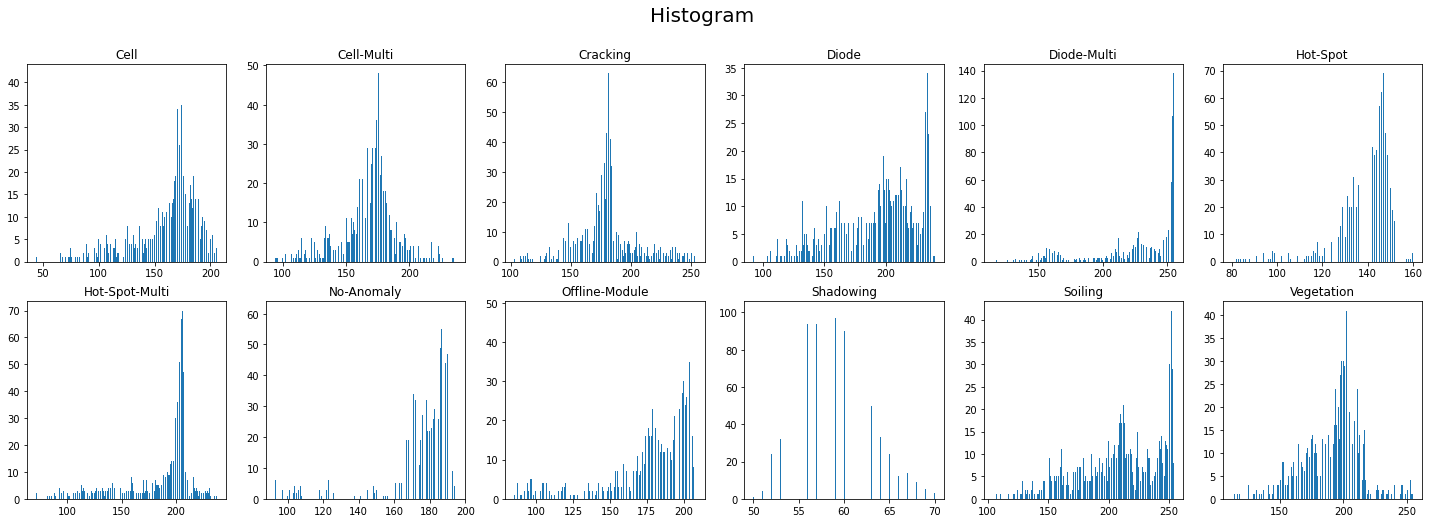

In [158]:
fig = plt.figure(figsize=(25, 8))
fig.suptitle('Histogram', fontsize=20)
for index, label in enumerate(classes):
  ax = plt.subplot(2, 6, index + 1)
  files = os.listdir('/content/dataset/' + label)
  image = np.array(Image.open('/content/dataset/' + label + '/' + str(files[0])))
  ax.hist(image.ravel(), bins=256)
  ax.set_title(label)


In [103]:
from skimage import filters

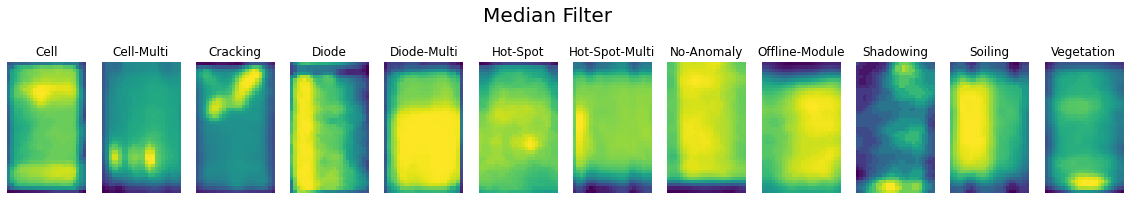

In [137]:
fig = plt.figure(figsize=(20, 3.5))
fig.suptitle('Median Filter', fontsize=20)
for index, label in enumerate(classes):
  ax = plt.subplot(1, 12, index + 1)
  files = os.listdir('/content/dataset/' + label)
  image = filters.median(np.array(Image.open('/content/dataset/' + label + '/' + str(files[0]))))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

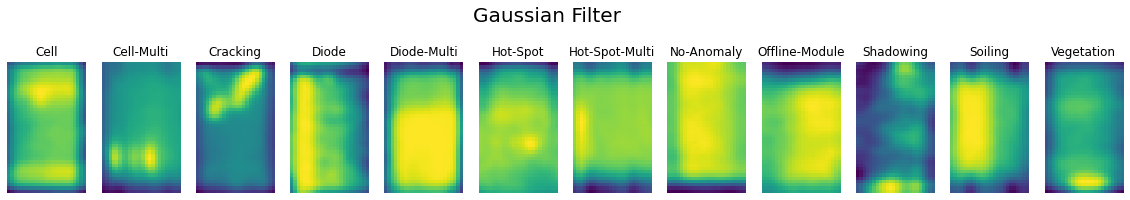

In [140]:
fig = plt.figure(figsize=(20, 3.5))
fig.suptitle('Gaussian Filter', fontsize=20)
for index, label in enumerate(classes):
  ax = plt.subplot(1, 12, index + 1)
  files = os.listdir('/content/dataset/' + label)
  image = filters.gaussian(np.array(Image.open('/content/dataset/' + label + '/' + str(files[0]))))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

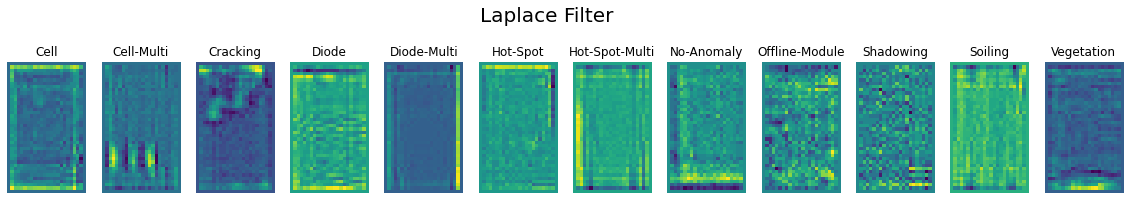

In [160]:
fig = plt.figure(figsize=(20, 3.5))
fig.suptitle('Laplace Filter', fontsize=20)
for index, label in enumerate(classes):
  ax = plt.subplot(1, 12, index + 1)
  files = os.listdir('/content/dataset/' + label)
  image = filters.laplace(np.array(Image.open('/content/dataset/' + label + '/' + str(files[0]))))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

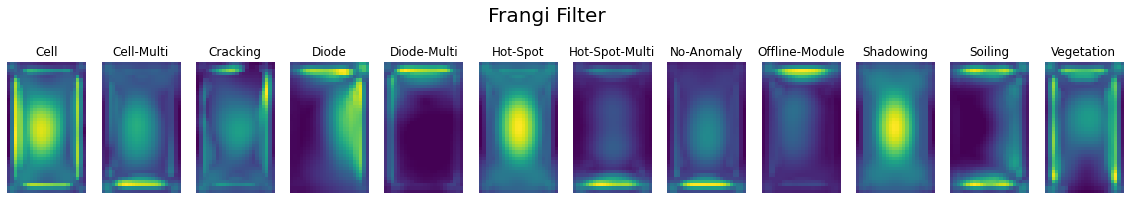

In [161]:
fig = plt.figure(figsize=(20, 3.5))
fig.suptitle('Frangi Filter', fontsize=20)
for index, label in enumerate(classes):
  ax = plt.subplot(1, 12, index + 1)
  files = os.listdir('/content/dataset/' + label)
  image = filters.frangi(np.array(Image.open('/content/dataset/' + label + '/' + str(files[0]))))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

# **Datagenerator**

Using **ImageDataGenerator** from Tensorflow to create tf compatible dataset.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Multiple augmentations are done
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2
)

In [47]:
train_dir = '/content/dataset'

In [48]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size = 64,
                                                  class_mode = 'sparse',
                                                  shuffle = True,
                                                  color_mode = 'grayscale',
                                                  target_size = (40,24))

val_generator = train_datagen.flow_from_directory(train_dir,
                                                  subset = 'validation',
                                                  batch_size = 64,
                                                  class_mode = 'sparse',
                                                  shuffle = True,
                                                  color_mode = 'grayscale',
                                                  target_size = (40,24))

Found 19903 images belonging to 12 classes.
Found 3976 images belonging to 12 classes.


# **Model and Training**

In [49]:
from tensorflow.keras import models, layers

In [64]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape = (40,24,1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(12)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 40, 24, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 12, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 6, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 6, 64)         18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 3, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 3, 64)         

In [65]:
# Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [68]:
# Callback to schedule Learning Rate using Time-based decay

from tensorflow.keras.callbacks import LearningRateScheduler

initial_learning_rate = 0.01
epochs = 200
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
epochs = 200
history1 = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs,
  callbacks=[early_stopping, LearningRateScheduler(lr_time_based_decay, verbose=1)],
  #class_weight=class_weight
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/200
311/311 [==============================] - 12s 38ms/step - loss: 1.7884 - accuracy: 0.4996 - val_loss: 1.7975 - val_accuracy: 0.5015

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009999500499949514.
Epoch 2/200
311/311 [==============================] - 11s 37ms/step - loss: 1.7405 - accuracy: 0.5010 - val_loss: 1.7257 - val_accuracy: 0.5015

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009998501203123563.
Epoch 3/200
311/311 [==============================] - 11s 36ms/step - loss: 1.7260 - accuracy: 0.5010 - val_loss: 1.7376 - val_accuracy: 0.5015

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000999700149540507.
Epoch 4/200
311/311 [==============================] - 12s 37ms/step - loss: 1.6901 - accuracy: 0.5014 - val_loss: 1.6298 - val_accuracy: 0.5053

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00099950026157611

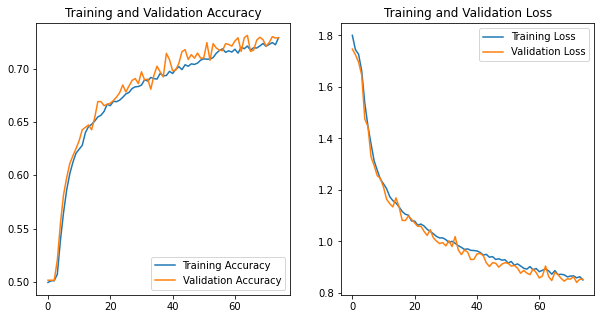

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, acc, label='Training Accuracy')
plt.plot(history.epoch, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, loss, label='Training Loss')
plt.plot(history.epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
loss, acc = model.evaluate(val_generator, verbose=2)
print("Model accuracy: {:5.2f}%".format(100 * acc))

63/63 - 2s - loss: 0.8111 - accuracy: 0.7382
Model accuracy: 73.82%


In [72]:
epochs = 100
history1 = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs,
  callbacks=[early_stopping, LearningRateScheduler(lr_time_based_decay, verbose=1)],
  #class_weight=class_weight
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0008607458439655602.
Epoch 1/100
311/311 [==============================] - 11s 36ms/step - loss: 0.8509 - accuracy: 0.7253 - val_loss: 0.8122 - val_accuracy: 0.7377

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008607028088251188.
Epoch 2/100
311/311 [==============================] - 12s 37ms/step - loss: 0.8479 - accuracy: 0.7282 - val_loss: 0.8485 - val_accuracy: 0.7349

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008606167668274625.
Epoch 3/100
311/311 [==============================] - 11s 36ms/step - loss: 0.8527 - accuracy: 0.7275 - val_loss: 0.8264 - val_accuracy: 0.7284

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0008604876662237205.
Epoch 4/100
311/311 [==============================] - 11s 36ms/step - loss: 0.8540 - accuracy: 0.7256 - val_loss: 0.8215 - val_accuracy: 0.7354

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0008603156298634

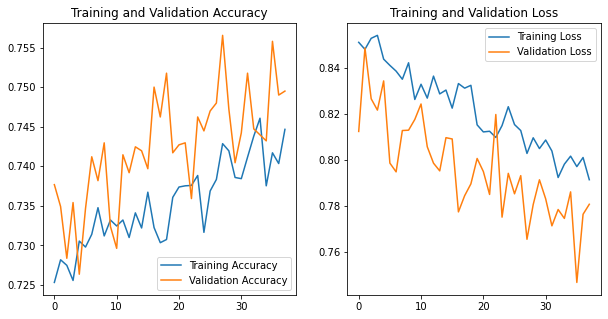

In [73]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.epoch, acc, label='Training Accuracy')
plt.plot(history1.epoch, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.epoch, loss, label='Training Loss')
plt.plot(history1.epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
loss, acc = model.evaluate(val_generator, verbose=2)
print("Model accuracy: {:5.2f}%".format(100 * acc))

63/63 - 2s - loss: 0.7663 - accuracy: 0.7452
Model accuracy: 74.52%


# **Testing**


*   Add the path to the hold out set in **test_dir** below.
*  Make sure that the hold out set is stored in the given format:

├──  **hold_out set /**   <br>
│    ├── class**1** / [entries] <br>
│    └── class**2** / entries] <br>
│    └──      .<br>
│    └──      .<br>
│    └── class**n** / entries] <br>

In [ ]:
test_dir = '/content/dataset'

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
test_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size = 64,
                                                  class_mode = 'sparse',
                                                  shuffle = True,
                                                  color_mode = 'grayscale',
                                                  target_size = (40,24))

In [ ]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape = (40,24,1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(12)
])

model.summary()



*   Download the **checkpoints folder** from: 
https://github.com/Kaustubh-Atey/Projects/tree/master/Project%20JUA/checkpoints
*   The **weights_0.75** file has weights for the model.
*   Add the path of **weights_0.75** file below in **model.load_weights()**



In [ ]:
# Restore the weights
model.load_weights('./checkpoints/weights_0.75')

# Evaluate the model
loss, acc = model.evaluate(val_generator, verbose=2)
print("Restored model accuracy: {:5.2f}%".format(100 * acc))